In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
!pip install pandas --upgrade

In [73]:
# Load the contents of our "best-models.joblib" file into a variable called "loaded_joblib"
loaded_joblib = joblib.load("C:/Users/aharo/OneDrive/Documents/GitHub/Prediction-of-Product-Sales/Data/best-models.joblib")

In [74]:
# Save each object from the loaded_joblib dictionary as a separate variable
X_train = loaded_joblib['X_train']
X_test = loaded_joblib['X_test']
y_train = loaded_joblib['y_train']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
lr = loaded_joblib['LinearRegression']
rf = loaded_joblib['RandomForestRegressor']

def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []

    # Loop through all transformers
    for name, trans, columns in column_transformer.transformers_:
        if trans == 'drop':
            continue
        elif isinstance(trans, Pipeline): 
            trans = trans.steps[-1][1]
        if hasattr(trans, 'get_feature_names_out'):
            # If the transformer has a 'get_feature_names_out' method
            names = list(trans.get_feature_names_out(columns))
            output_features += names
        elif hasattr(trans, 'get_feature_names'):
            # If the transformer has a 'get_feature_names' method
            names = list(trans.get_feature_names(columns))
            output_features += names
        else:
            output_features += columns

    return output_features

feature_names = get_feature_names(preprocessor)


# Explaining our tree-based model with shap

In [75]:
# Create an X_shap and y_shap variable from your training data
X_shap = shap.sample(X_train, 100)
y_shap = y_train.loc[X_shap.index]

In [76]:
# Preprocess X_shap
X_shap_preprocessed = preprocessor.transform(X_shap)

In [77]:
import numpy as np
# Convert the preprocessed X_shap to DataFrame
X_shap_df = pd.DataFrame(X_shap_preprocessed.toarray(), columns=feature_names)

In [78]:
# Create a model explainer
explainer = shap.TreeExplainer(rf)

In [79]:
# Calculate the shap values for your model
shap_values = explainer.shap_values(X_shap_df)

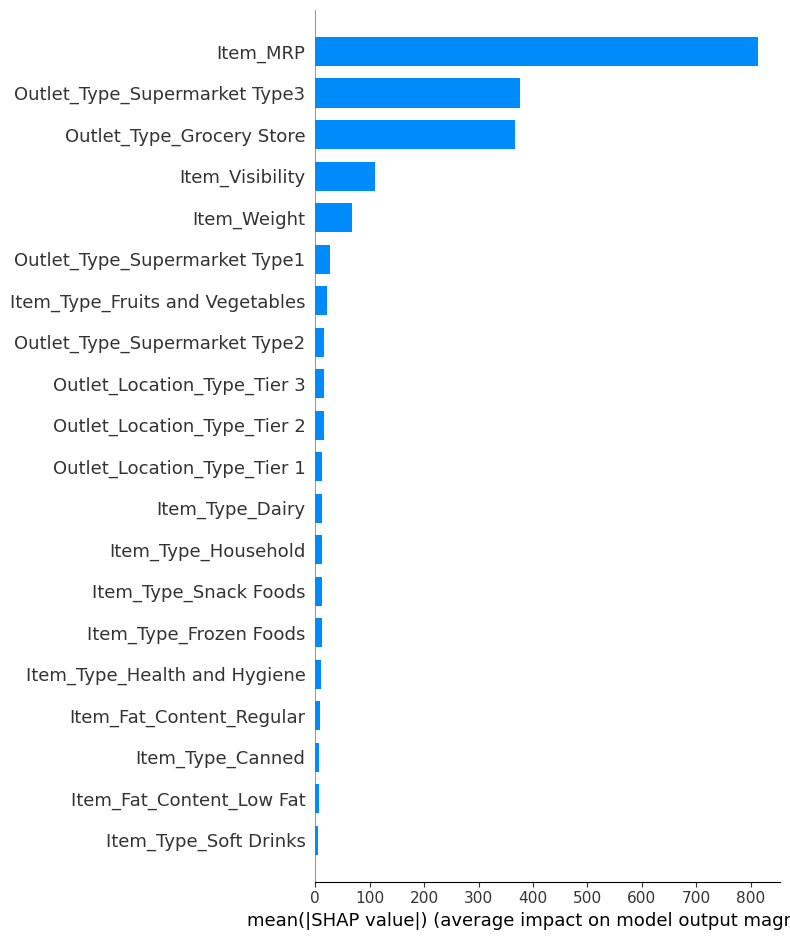

In [80]:
# Create a summary plot - with plot_type='bar'
shap.summary_plot(shap_values, X_shap_df, plot_type="bar", show=False)
plt.savefig("shap_importance.png", bbox_inches='tight')

# Summary Plot - Bar Version

This plot represents the average impact of each feature on the model's output. The y-axis shows the names of the features, and the x-axis represents the average absolute SHAP value, a measure of the magnitude of a feature's effect on the output. The larger the SHAP value, the higher the impact of the feature on the model's prediction.

# Comparison of Most Important Features: SHAP vs. Feature Importance

The SHAP values and Random Forest's feature importance don't completely align, and here's why:

1. SHAP values take into account not only the direct impact of a feature on the output but also its interaction with other features. This makes SHAP values a more comprehensive measure of feature importance.



2. The Random Forest model rates Item_MRP as the most important feature, while SHAP values rank Outlet_Type_Supermarket Type3 at the top. This could be because traditional feature importance measures like those from a Random Forest may be biased towards variables that have more categories or are numeric.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


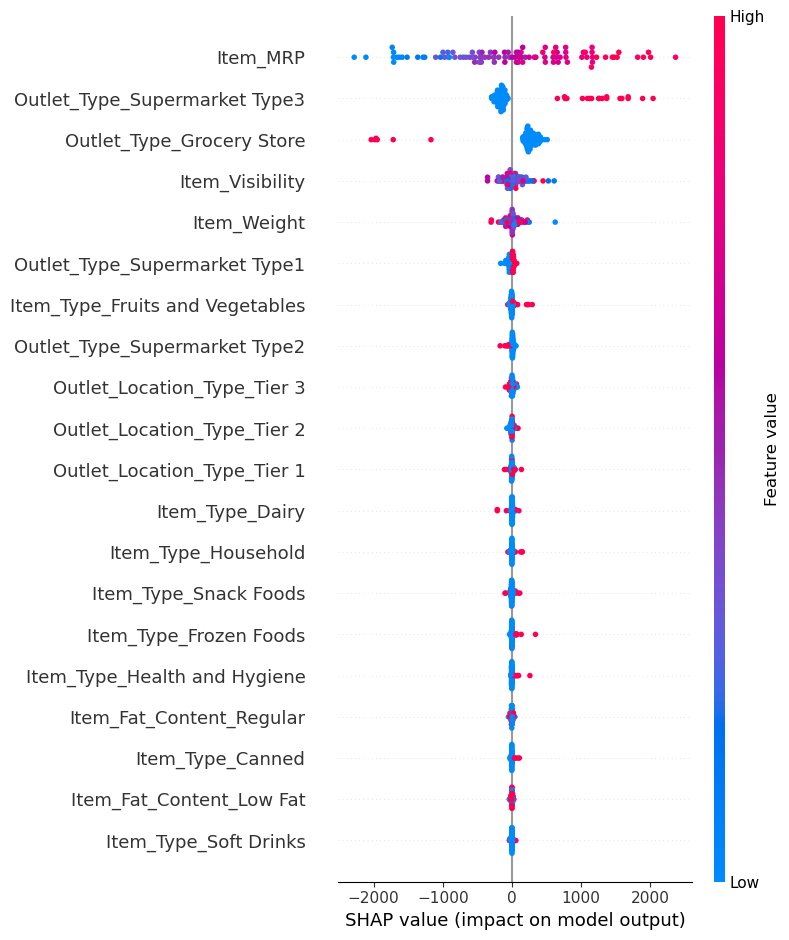

In [81]:
shap.summary_plot(shap_values, X_shap_df, show=False)
plt.savefig("shap_importance_dot.png", bbox_inches='tight')

# Summary Plot - Dot Version

This plot shows the impact of each feature on the model's prediction for individual instances. Each dot represents an instance (or a row) from the dataset. The color represents the feature's value (high in red, low in blue). The position on the x-axis shows whether the effect of that value is associated with a higher or lower prediction.

# Interpretation of the Top 3 Most Important Features


1. Outlet_Type_Supermarket Type3: This feature has the most significant impact on sales. If a store is a "Supermarket Type3", it tends to be associated with higher sales. Conversely, if a store is not of this type, it is likely to have lower sales.



2. Item_MRP: This is the price of the product. More expensive items (Item_MRP high, shown in red) are associated with higher sales, while cheaper items (low Item_MRP, shown in blue) tend to have lower sales.



3. Outlet_Type_Grocery Store: If an outlet is a grocery store, it is likely to have lower sales. If it's not a grocery store, the sales are likely to be higher.

# Local Explanations

## LIME Tabular Explanation

In [87]:
!pip install lime
import lime
import lime.lime_tabular

In [96]:
# Load the X_shap_df DataFrame from the provided CSV file
X_shap_df = pd.read_csv("C:\\Users\\aharo\\OneDrive\\Documents\\GitHub\\Prediction-of-Product-Sales\\X_shap_df.csv")

In [97]:
# Instances with low and high predicted sales
low_sales_instance = X_shap_df.iloc[0]
high_sales_instance = X_shap_df.iloc[1]

In [98]:
# Print the instances
print("Low sales instance:")
print(low_sales_instance)
print("\nHigh sales instance:")
print(high_sales_instance)

Low sales instance:
Item_Weight                        0.092200
Item_Visibility                   -0.434999
Item_MRP                           0.650588
Item_Fat_Content_Low Fat           1.000000
Item_Fat_Content_Regular           0.000000
Item_Type_Baking Goods             0.000000
Item_Type_Breads                   0.000000
Item_Type_Breakfast                0.000000
Item_Type_Canned                   0.000000
Item_Type_Dairy                    0.000000
Item_Type_Frozen Foods             0.000000
Item_Type_Fruits and Vegetables    0.000000
Item_Type_Hard Drinks              0.000000
Item_Type_Health and Hygiene       0.000000
Item_Type_Household                0.000000
Item_Type_Meat                     0.000000
Item_Type_Others                   0.000000
Item_Type_Seafood                  0.000000
Item_Type_Snack Foods              1.000000
Item_Type_Soft Drinks              0.000000
Item_Type_Starchy Foods            0.000000
Outlet_Location_Type_Tier 1        0.000000
Outlet_Locat

In [101]:
# Create a model explainer
explainer = shap.TreeExplainer(rf)

In [102]:
# Generate SHAP values for these instances
shap_values_low = explainer.shap_values(low_sales_instance.values.reshape(1, -1))
shap_values_high = explainer.shap_values(high_sales_instance.values.reshape(1, -1))

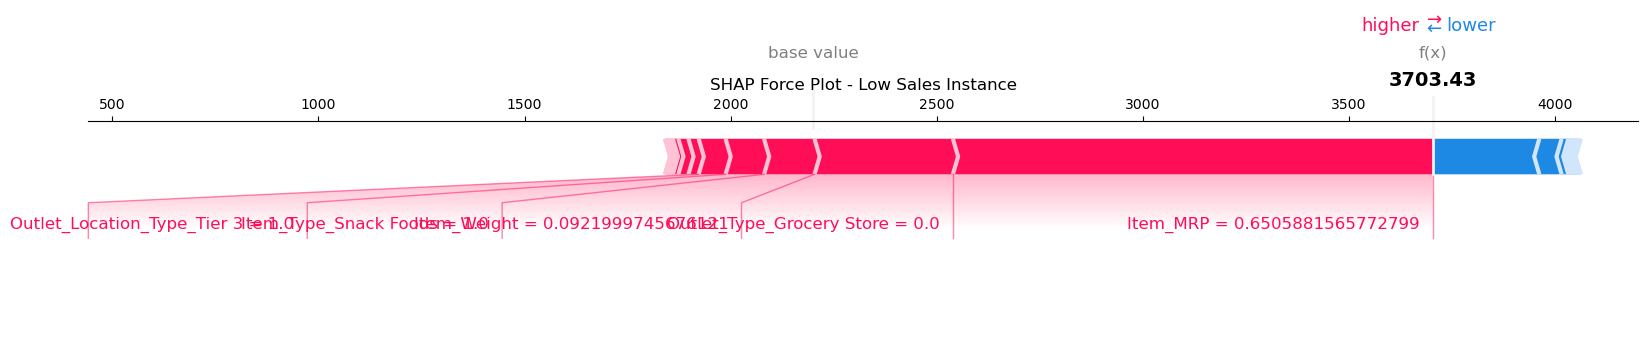

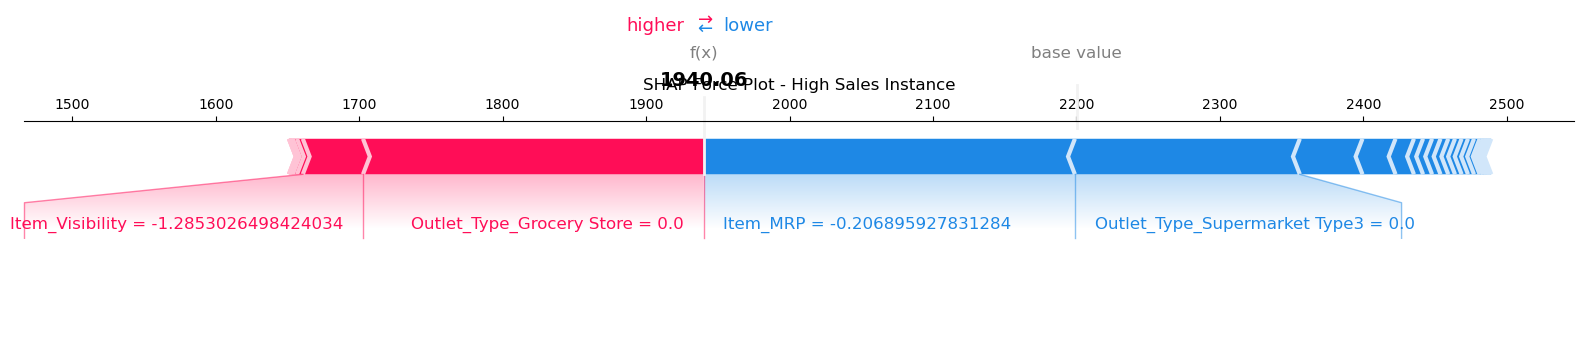

In [103]:
# Plot the SHAP Individual Force Plots
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_low, low_sales_instance, matplotlib=True, show=False)
plt.title("SHAP Force Plot - Low Sales Instance")
plt.savefig("shap_force_plot_low.png", bbox_inches='tight')
plt.show()

shap.force_plot(explainer.expected_value, shap_values_high, high_sales_instance, matplotlib=True, show=False)
plt.title("SHAP Force Plot - High Sales Instance")
plt.savefig("shap_force_plot_high.png", bbox_inches='tight')
plt.show()

In [117]:
categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type']
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])

# Combine the encoded categorical variables with numerical variables
X_train_processed = np.hstack((X_train_encoded, X_train.drop(categorical_cols, axis=1)))

# Create a StandardScaler for numerical variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(categorical_cols, axis=1))

# Combine the scaled numerical variables with encoded categorical variables
X_train_processed = np.hstack((X_train_encoded, X_train_scaled))

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


ValueError: could not convert string to float: 'OUT049'

In [114]:
# Create a LIME explainer
explainer_lime = LimeTabularExplainer(X_train_processed, 
                                      feature_names=list(encoder.get_feature_names_out(categorical_cols)) + X_train.drop(categorical_cols, axis=1).columns.tolist(),
                                      class_names=['Sales'], 
                                      verbose=True, 
                                      mode='regression',
                                      discretize_continuous=False)  # Disable discretization

ValueError: could not convert string to float: 'OUT049'